In [1]:
import mnist
import scipy.misc
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import random
from einops import rearrange, reduce, repeat
from skimage.transform import resize
from tqdm.notebook import tqdm


In [2]:
#import gc
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()

0


In [3]:
# Define a transform to normalize the data

transform = transforms.Compose([
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,)) # normalize the data
])

# Download the MNIST training set and apply the transform
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Download the MNIST test set and apply the transform
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Create a dataloader to load the training set in batches during training
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create a dataloader to load the test set in batches during evaluation
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
print(len(trainset))


60000


In [4]:
trainset[1][0][0].shape

torch.Size([28, 28])

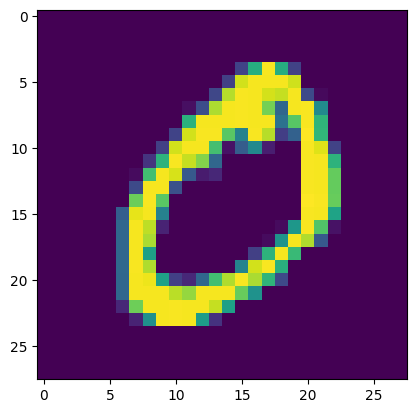

In [5]:
plt.imshow(trainset[1][0][0])

In [6]:
#import torchvision
#from torch.utils.data import DataLoader

#train_data = torchvision.datasets.MNIST

#images = mnist.train_images()
#labels = mnist.train_labels()

#def convert(image): return t.tensor(image.flatten()).float()
#train = t.stack([t.tensor(x,dtype=t.float)/256.0 for x in mnist.train_images()])
#mean = train.mean(dim=(0,1,2), keepdim=True)
#std = train.std(dim=(0,1,2), keepdim=True)
#train_normalized = (train - mean) / std

In [7]:
latent_dim = 10 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(784, latent_dim)
        self.decoder = nn.Linear(latent_dim, 784)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

  0%|                                                                                                         …

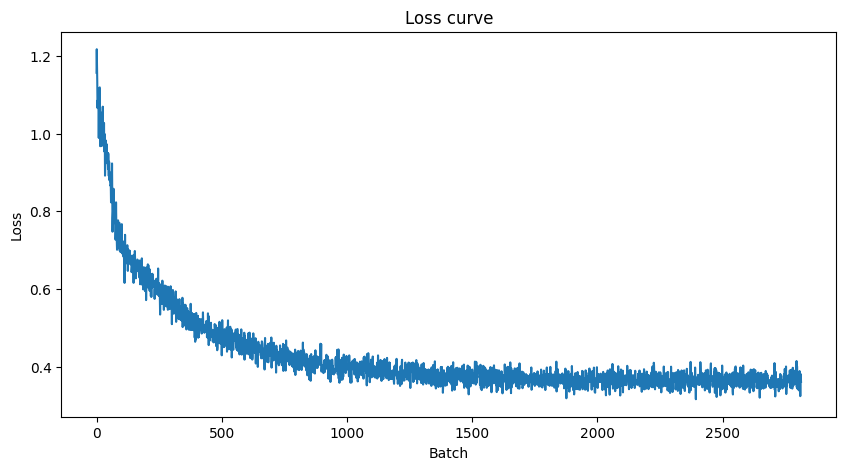

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
autoencoder.train()

num_epochs = 3
# Initialize tqdm with the total number of epochs
pbar = tqdm(total=num_epochs, dynamic_ncols=True)

# To keep track of the loss during training
losses = []

# Train the autoencoder
for epoch in range(num_epochs):  # train for num_epochs epochs
    for batch_idx, (data, _) in enumerate(trainloader):
        optimizer.zero_grad()  # zero the gradients
        data = data.to(device)
        data = data.view(data.size(0), -1)  # flatten the images
        recon = autoencoder(data)  # forward pass
        loss = loss_fn(recon, data)  # compute the loss
        loss.backward()  # backward pass
        optimizer.step()  # update the parameters

        losses.append(loss.item())

        if batch_idx % 1000 == 0:
            # Update the description in the progress bar
            pbar.set_postfix({'Epoch': epoch, 'Batch': batch_idx, 'Loss': loss.item()}, refresh=True)
            t.save(autoencoder.state_dict(), 'autoencoder.pt')

    # Update the tqdm progress bar
    pbar.update(1)

# Save the trained model
t.save(autoencoder.state_dict(), 'autoencoder.pt')

# Close the tqdm progress bar
pbar.close()

# After training, plot the loss curve
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.title('Loss curve')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()


Autoencoder(
  (encoder): Linear(in_features=784, out_features=10, bias=True)
  (decoder): Linear(in_features=10, out_features=784, bias=True)
)


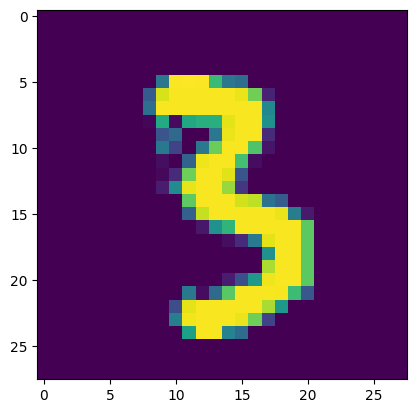

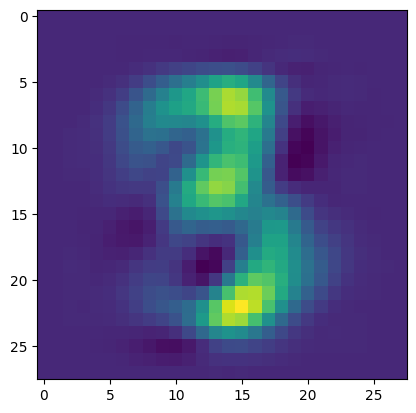

In [10]:
# Define the autoencoder
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder.pt'))
autoencoder.eval()
print(autoencoder)

# Get a batch of data from the trainloader
data_iter = iter(trainloader)
images, labels = next(data_iter)  # corrected line

# Pass the images through the autoencoder and reshape the output
reconstructed_images = rearrange(autoencoder(images.view(images.size(0),-1)), 'batch (height width) -> batch height width', height=28)

# Plot the original image
plt.figure()
plt.imshow(images[0][0].detach().numpy())

# Plot the reconstructed image
plt.figure()
plt.imshow(reconstructed_images[0].detach().numpy())


In [39]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)  # Use nn.Dropout for 2D data
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


  0%|                                                                                                         …

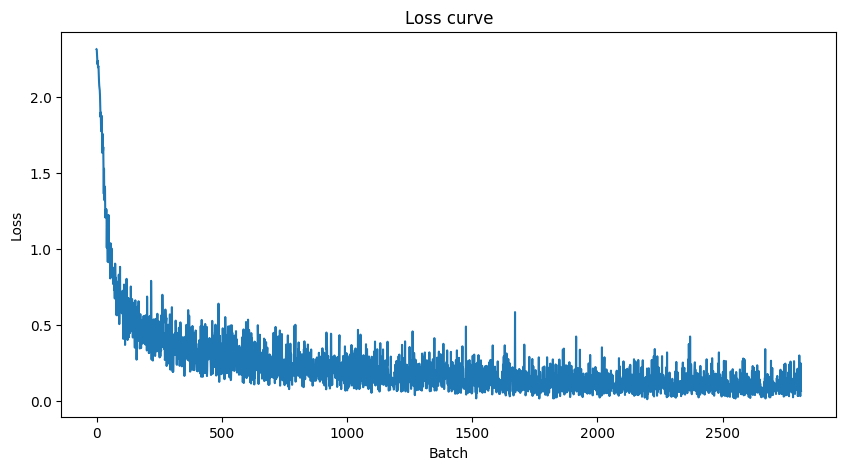

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = DigitClassifier()
classifier = classifier.to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
classifier.train()

# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 3
# Initialize tqdm with the total number of epochs
pbar = tqdm(total=num_epochs, dynamic_ncols=True)

# To keep track of the loss during training
losses = []
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (data, label) in enumerate(trainloader):
        optimizer.zero_grad()  # zero the gradients
        data = data.to(device)
        label = label.to(device)
        data = data.view(-1, 1, 28, 28)  # reshape the images
        logits = classifier(data)  # forward pass
        loss = nn.CrossEntropyLoss()(logits, label)
        loss.backward()  # backward pass
        optimizer.step()  # update the parameters

        losses.append(loss.item())

        if batch_idx % 500 == 0:
            pbar.set_postfix({'Epoch': epoch, 'Batch': batch_idx, 'Loss': loss.item()}, refresh=True)

    scheduler.step()
    pbar.update(1)


# Save the trained model
t.save(classifier.state_dict(), 'classifier.pt')

# Close the tqdm progress bar
pbar.close()

# After training, plot the loss curve
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.title('Loss curve')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()


In [43]:
classifier = DigitClassifier()
classifier.load_state_dict(t.load('classifier.pt'))
classifier.eval()
print(classifier)

DigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = classifier.to(device)
classifier.eval()

correct = []
for batch_idx, (data, label) in enumerate(testloader):
    data = data.to(device)
    label = label.to(device)
    # data = data.view(data.size(0), -1)  # Don't flatten the images
    logits = classifier(data)  # forward pass
    _, predicted = torch.max(logits, 1)  # Get the index of the max log-probability
    correct.append((predicted == label).float().sum().item())

accuracy = sum(correct) / len(testset)

print("Test accuracy: ", accuracy)


Test accuracy:  0.9824


In [46]:
for a,(b,c) in enumerate(testloader):
    print(b.shape)
    break

torch.Size([1, 1, 28, 28])


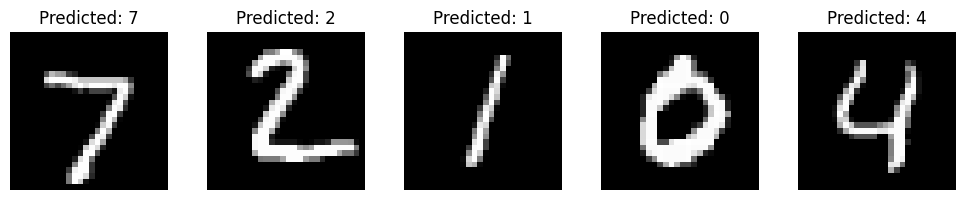

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the first batch of images and labels from the test loader
images, labels = next(iter(torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)))

# Move the images to the GPU and flatten them
images = images.to(device)
#images_flattened = images.view(images.size(0), -1)

# Pass the images through the classifier
outputs = classifier(images)#_flattened)

# Get the predicted labels
_, predicted = torch.max(outputs, 1)

# Move the images and predicted labels back to the CPU for visualization
images = images.cpu()
predicted = predicted.cpu()

# Display the first 5 images and their predicted labels
plt.figure(figsize=(10, 2))  # set the size of the figure
for i in range(5):
    plt.subplot(1, 5, i+1)  # plot subfigure, arguments are nrows, ncols, index
    plt.imshow(images[i][0].detach().numpy(), cmap='gray')  # display image
    plt.title('Predicted: {}'.format(predicted[i].item()))  # display predicted label as title
    plt.axis('off')  # turn off the axis
plt.tight_layout()  # automatically adjust subplot parameters to give specified padding
plt.show()


In [65]:
classifier = DigitClassifier()
classifier.load_state_dict(torch.load('classifier.pt'))
classifier = classifier.to(device)
classifier.eval()

target_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # List of target classes to optimize for
num_classes = len(target_classes)
learning_rate = 0.001
num_iterations = 10000

# Initialize the input tensor with random values
input_tensor = torch.randn(num_classes, latent_dim, requires_grad=True).to(device).detach().requires_grad_()
optimizer = torch.optim.Adam([input_tensor], lr=learning_rate)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Placeholder to store the losses for each target class
losses = {target_class: [] for target_class in target_classes}

# Perform gradient ascent to maximize the probability of each target class
for i in tqdm(range(num_iterations), desc='Optimizing input tensors'):
    optimizer.zero_grad()
    # Forward pass through the model
    logits = classifier(autoencoder.decoder(input_tensor).view(-1, 1, 28, 28))

    total_loss = 0
    # Compute the loss for each target class
    for j, target_class in enumerate(target_classes):
        loss = loss_fn(logits[j].unsqueeze(0), torch.tensor([target_class]).to(device))
        total_loss += loss
        # Store the loss
        losses[target_class].append(loss.item())
    total_loss.backward()
    optimizer.step()


Optimizing input tensors:   0%|          | 0/10000 [00:00<?, ?it/s]

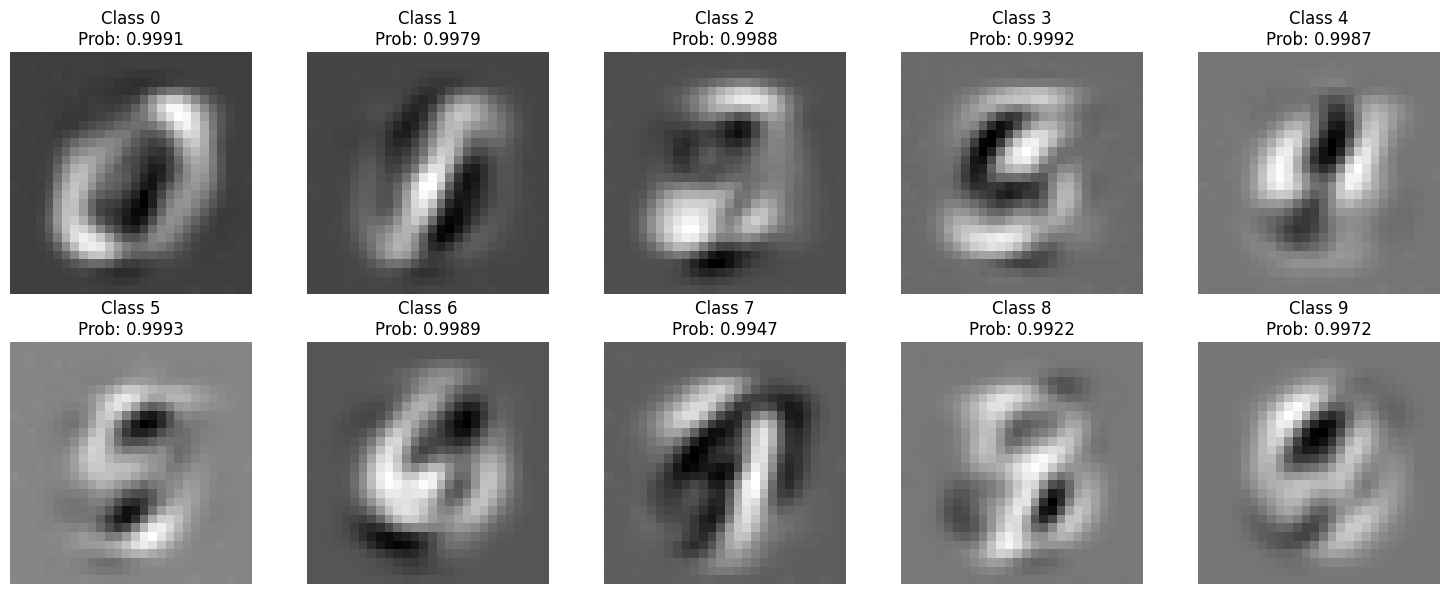

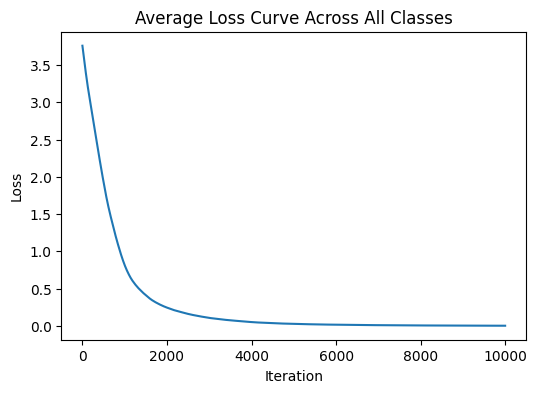

In [71]:
# Calculate average loss for each iteration
average_losses = [sum(losses)/num_classes for losses in zip(*losses.values())]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, num_classes // 2, figsize=(15, 6))

# Print the final input tensors and probabilities of the target classes
for j, target_class in enumerate(target_classes):
    # Reshape the output of the decoder to match the input shape expected by the classifier
    reshaped_output = autoencoder.decoder(input_tensor[j].unsqueeze(0)).view(-1, 1, 28, 28)
    final_prob = torch.nn.functional.softmax(classifier(reshaped_output),dim=-1)[0, target_class].item()

    # Plot the optimized input for each class
    i = j // (num_classes // 2)
    k = j % (num_classes // 2)
    axs[i, k].imshow(rearrange(autoencoder.decoder(input_tensor[j].unsqueeze(0))[0], '(h w) -> h w', h = 28).cpu().detach().numpy(), cmap='gray')
    axs[i, k].set_title(f'Class {target_class}\nProb: {final_prob:.4f}')
    axs[i, k].axis('off')

# Show the figure
plt.tight_layout()
plt.show()

# Plot the average loss curve
plt.figure(figsize=(6, 4))
plt.plot(average_losses)
plt.title('Average Loss Curve Across All Classes')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


Optimizing input tensors:   0%|          | 0/10000 [00:00<?, ?it/s]

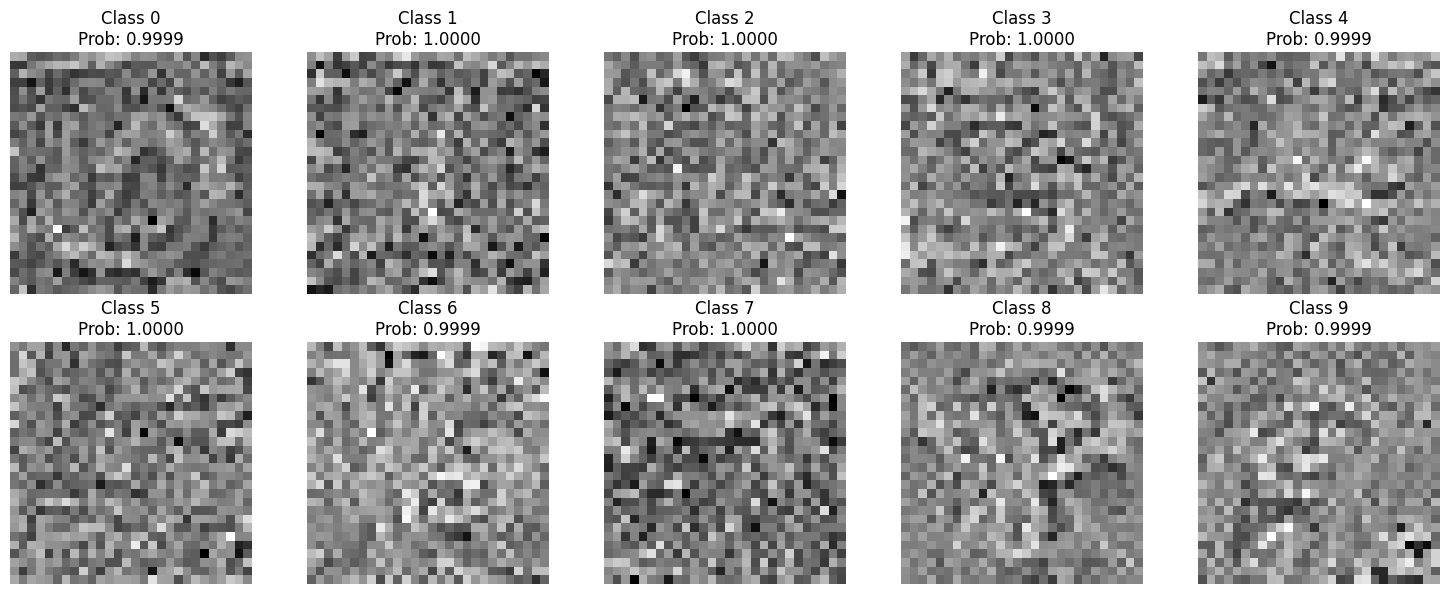

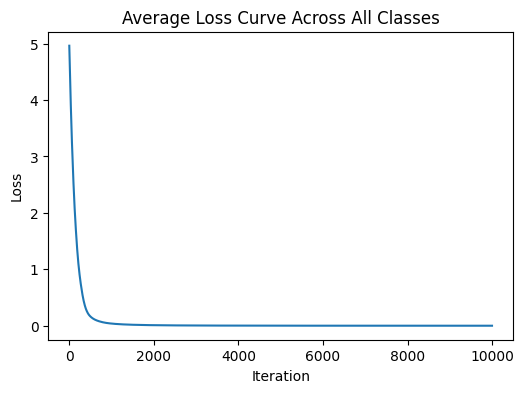

In [73]:
# Initialize the input tensor with random values
input_tensor = torch.randn(num_classes, 1, 28, 28, requires_grad=True).to(device).detach().requires_grad_()
optimizer = torch.optim.Adam([input_tensor], lr=learning_rate)

# Placeholder to store the losses for each target class
losses = {target_class: [] for target_class in target_classes}

# Perform gradient ascent to maximize the probability of each target class
for i in tqdm(range(num_iterations), desc='Optimizing input tensors'):
    optimizer.zero_grad()
    # Forward pass through the model
    logits = classifier(input_tensor)

    total_loss = 0
    # Compute the loss for each target class
    for j, target_class in enumerate(target_classes):
        loss = loss_fn(logits[j].unsqueeze(0), torch.tensor([target_class]).to(device))
        total_loss += loss
        # Store the loss
        losses[target_class].append(loss.item())
    total_loss.backward()
    optimizer.step()

# Print the final input tensors and probabilities of the target classes
fig, axs = plt.subplots(2, num_classes // 2, figsize=(15, 6))

for j, target_class in enumerate(target_classes):
    final_prob = torch.nn.functional.softmax(classifier(input_tensor[j].unsqueeze(0)),dim=-1)[0, target_class].item()

    # Plot the optimized input for each class
    i = j // (num_classes // 2)
    k = j % (num_classes // 2)
    axs[i, k].imshow(input_tensor[j, 0].cpu().detach().numpy(), cmap='gray')
    axs[i, k].set_title(f'Class {target_class}\nProb: {final_prob:.4f}')
    axs[i, k].axis('off')

plt.tight_layout()
plt.show()

# Plot the average loss curve
average_losses = [sum(losses)/num_classes for losses in zip(*losses.values())]
plt.figure(figsize=(6, 4))
plt.plot(average_losses)
plt.title('Average Loss Curve Across All Classes')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Define the model
model = DigitClassifier()

# Create a dictionary to store the activations of each layer
activations = {}

# Define the forward hook function to capture the activations of each layer
def capture_activations(name):
    def hook(model, input, output):
        activations[name] = output
    return hook

# Register the forward hook for each layer of the model
for name, module in model.named_modules():
    module.register_forward_hook(capture_activations(name))

# Forward pass the input through the model to capture the activations
input_tensor = torch.randn(1, 784)
model(input_tensor)

# Print the activations of each layer
#for name, output in activations.items():
#    print(f'{name}: {output}')


In [ ]:
activations.keys()

In [ ]:
t.tensor(3)